In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import joypy

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Function to get rid of outliers

def outliers_removal(df : pd.DataFrame, column : str):

    if df[column].dtype in ['int64', 'float64']:

        q1 = df[column].quantile(.25)
        q3 = df[column].quantile(.75)
        IQR = q3 -q1

        condition = (df[column] < (q1 - 1.5 * IQR)) | (df[column]> (q3 + 1.5 * IQR))

        df_cleaned = df[~condition]

        df_cleaned = df_cleaned.reset_index(drop=True)
    
    else:
        print('Column is not numerical')
        df_cleaned = df
        pass

    return df_cleaned

In [4]:
df = pd.read_csv('data/phl_data.csv') 

In [5]:
# Filter outliers and store each filtered daatsets in a dictionary

cleaned_series = {}

for column in df.columns:
    if column in df.drop(['P_NAME', 'P_YEAR', 'P_DETECTION', 'P_ESI', 'P_HABITABLE', 'P_TYPE_TEMP', 'P_HABZONE_CON', 'P_HABZONE_OPT', 'P_TYPE', 'S_NAME', 'S_RA', 'S_DEC', 'S_TYPE', 'hip_name', 'hd_name', 'matched'], axis = 1).columns:
        cleaned_series['df_cleaned_pl_{0}'.format(column)] = outliers_removal(df, column)

Column is not numerical


Exploratory analysis

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_10440\2578340184.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.drop(['P_NAME', 'P_YEAR', 'P_DETECTION', 'P_ESI', 'P_HABITABLE', 'P_TYPE_TEMP', 'P_HABZONE_CON', 'P_HABZONE_OPT', 'P_INCLINATION', 'P_TYPE', 'S_NAME', 'S_RA', 'S_DEC', 'S_TYPE', 'hip_name', 'hd_name', 'matched'], axis = 1).corr(), cbar_kws={"shrink": 0.9}, square=True, vmin=-1, vmax=1, annot=True)


Text(0.5, 1.0, 'Correlation')

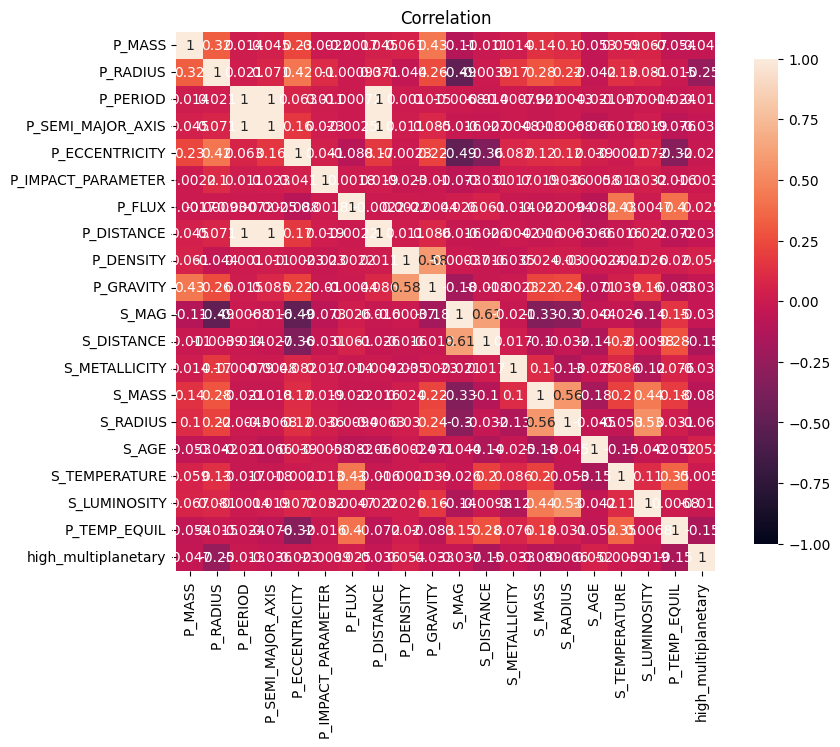

In [6]:
## Correlation between variables (planets and their stars variables)

plt.figure(figsize=(10,7))

# Dropping some variables of no interest and categorical ones

heatmap = sns.heatmap(df.drop(['P_NAME', 'P_YEAR', 'P_DETECTION', 'P_ESI', 'P_HABITABLE', 'P_TYPE_TEMP', 'P_HABZONE_CON', 'P_HABZONE_OPT', 'P_INCLINATION', 'P_TYPE', 'S_NAME', 'S_RA', 'S_DEC', 'S_TYPE', 'hip_name', 'hd_name', 'matched'], axis = 1).corr(), cbar_kws={"shrink": 0.9}, square=True, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation')

Strong correlation between planet distance and period/semi major axis. Also between star distance and star magnitude.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


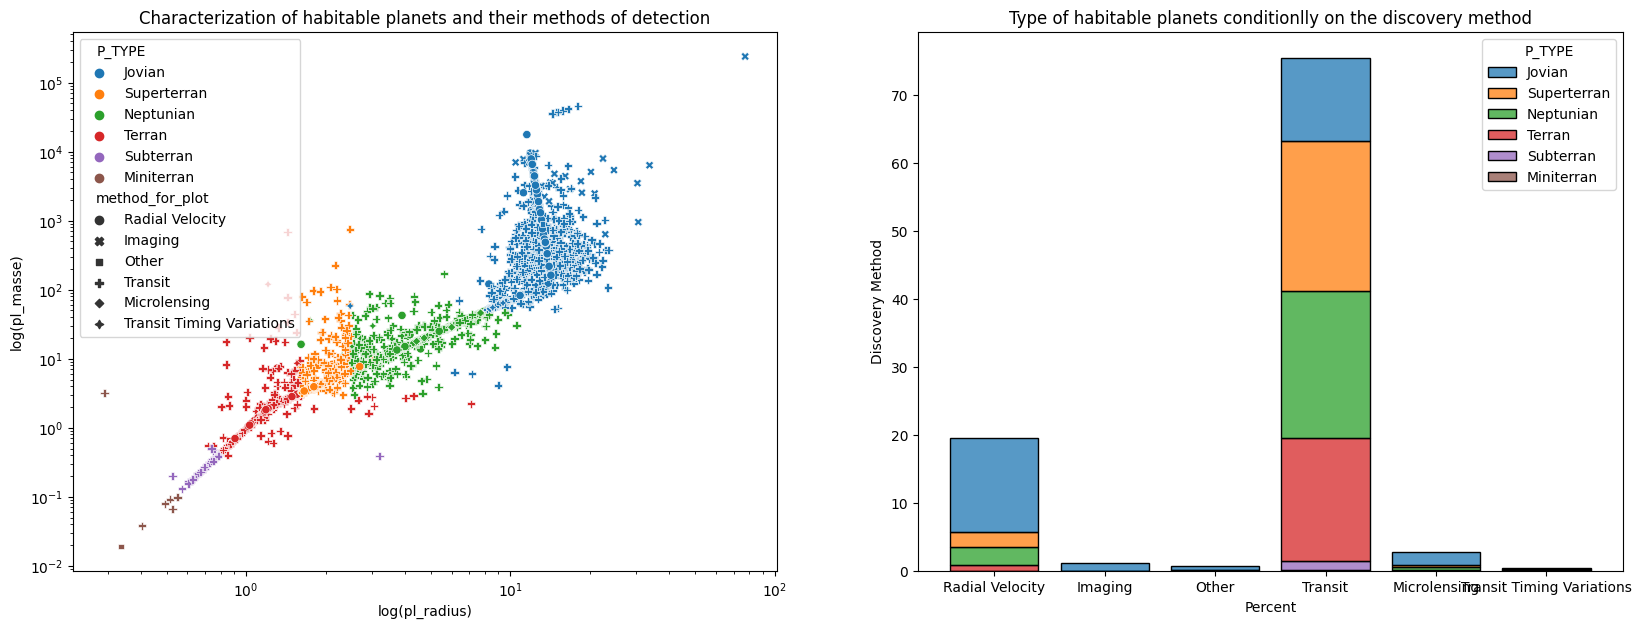

In [7]:
top_methods = df['P_DETECTION'].value_counts().head(5).index.tolist()

df['method_for_plot'] = df['P_DETECTION'].apply(lambda x: x if x in top_methods else 'Other')

palette = {method: sns.color_palette('tab10', n_colors=len(top_methods))[i] for i, method in enumerate(top_methods)}
palette['Other'] = 'black'

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 7))
ax1.set(xscale="log", yscale="log")
ax1.set_title('Characterization of habitable planets and their methods of detection')
ax1.set_ylabel('log(pl_masse)')
ax1.set_xlabel('log(pl_radius)')
ax1.legend(loc='upper left')
sns.scatterplot(data=df, x="P_RADIUS", y="P_MASS", hue='P_TYPE', style = 'method_for_plot', ax=ax1)
sns.histplot(df, x = 'method_for_plot', hue = 'P_TYPE', multiple='stack', shrink=0.8, stat='percent')
ax2.set_title('Type of habitable planets conditionlly on the discovery method')
ax2.set_ylabel('Discovery Method')
ax2.set_xlabel('Percent')

plt.show()

Clear clusters appear regarding the planet type : Jovian types' planets appear to be the one with the biggest radius. The Neptunian ones have a slightly lower radius, followed by the Superterran, the Terran, the Subterran and the Miniterran. We can confidently suggest that the type of the planet hence strongly depends on its radius. Similarly, but less obviously, planets with a highest mass seem to be the Jovian one, and the smallest mass are Miniterran and Subterran. It also emphasizes the fact that the type of each planets have been correctly decided as they are aligned with the planets' theories.
On the other hand, smallest radius and mass planets (Subterran and Miniterran) have mostly been detected using Transit method and nothing else. Transit method is the most widely used one, but doesn't seem to fit well for small planets. Besides those two types of planets, it is able to detect most other types. Radial velocity also is quite used for many different types, although more for Jovian planets. Imaging seems to have only detected Jovian planets, hence big planets.

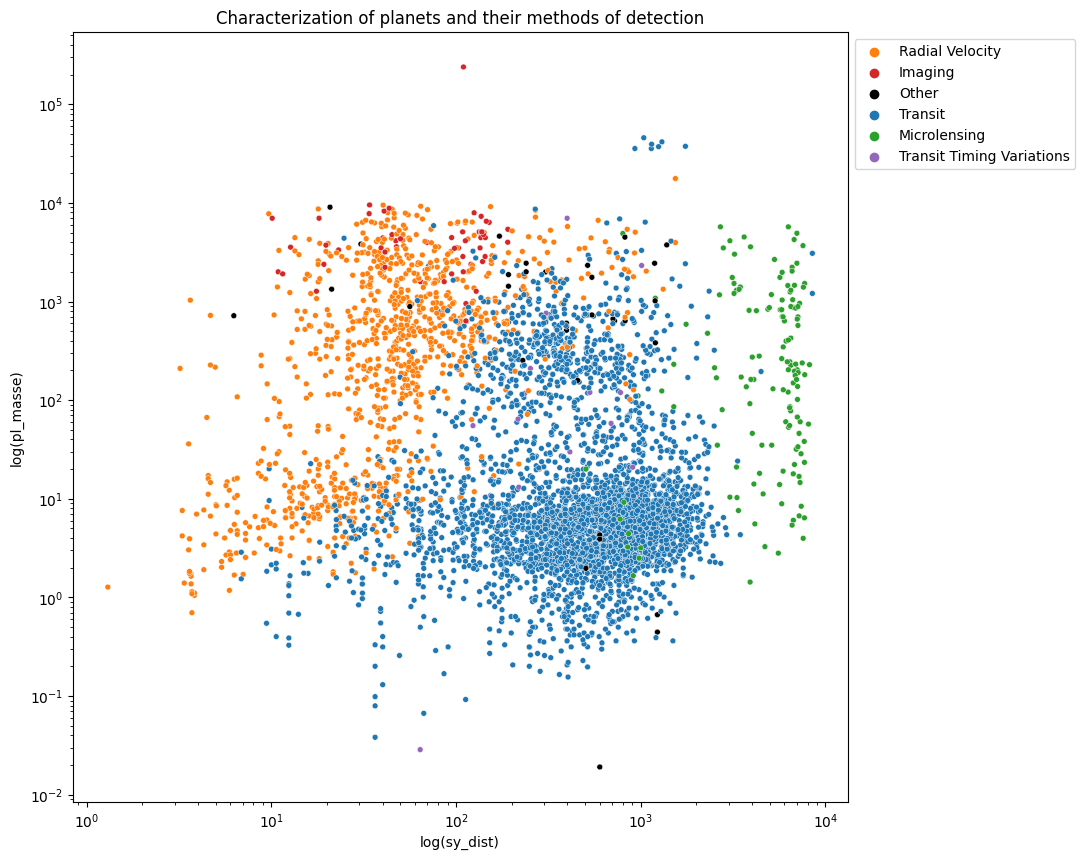

In [8]:
# Characterization of planets and their methods of detection

top_methods = df['P_DETECTION'].value_counts().head(5).index.tolist()

df['method_for_plot'] = df['P_DETECTION'].apply(lambda x: x if x in top_methods else 'Other')

palette = {method: sns.color_palette('tab10', n_colors=len(top_methods))[i] for i, method in enumerate(top_methods)}
palette['Other'] = 'black'

f, ax = plt.subplots(figsize=(10, 10))
ax.set(xscale="log", yscale="log")
ax.set_title('Characterization of planets and their methods of detection')
ax.set_ylabel('log(pl_masse)')
ax.set_xlabel('log(sy_dist)')
sns.scatterplot(data=df, x="S_DISTANCE", y="P_MASS", hue='method_for_plot', palette=palette, ax=ax, s=17.7)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

Here again, we see that imaging (red dots) is only capable of detecting big planets, while transit is quite good for everything. Microlensing is very specific for the furthest planets.

Conditional densities

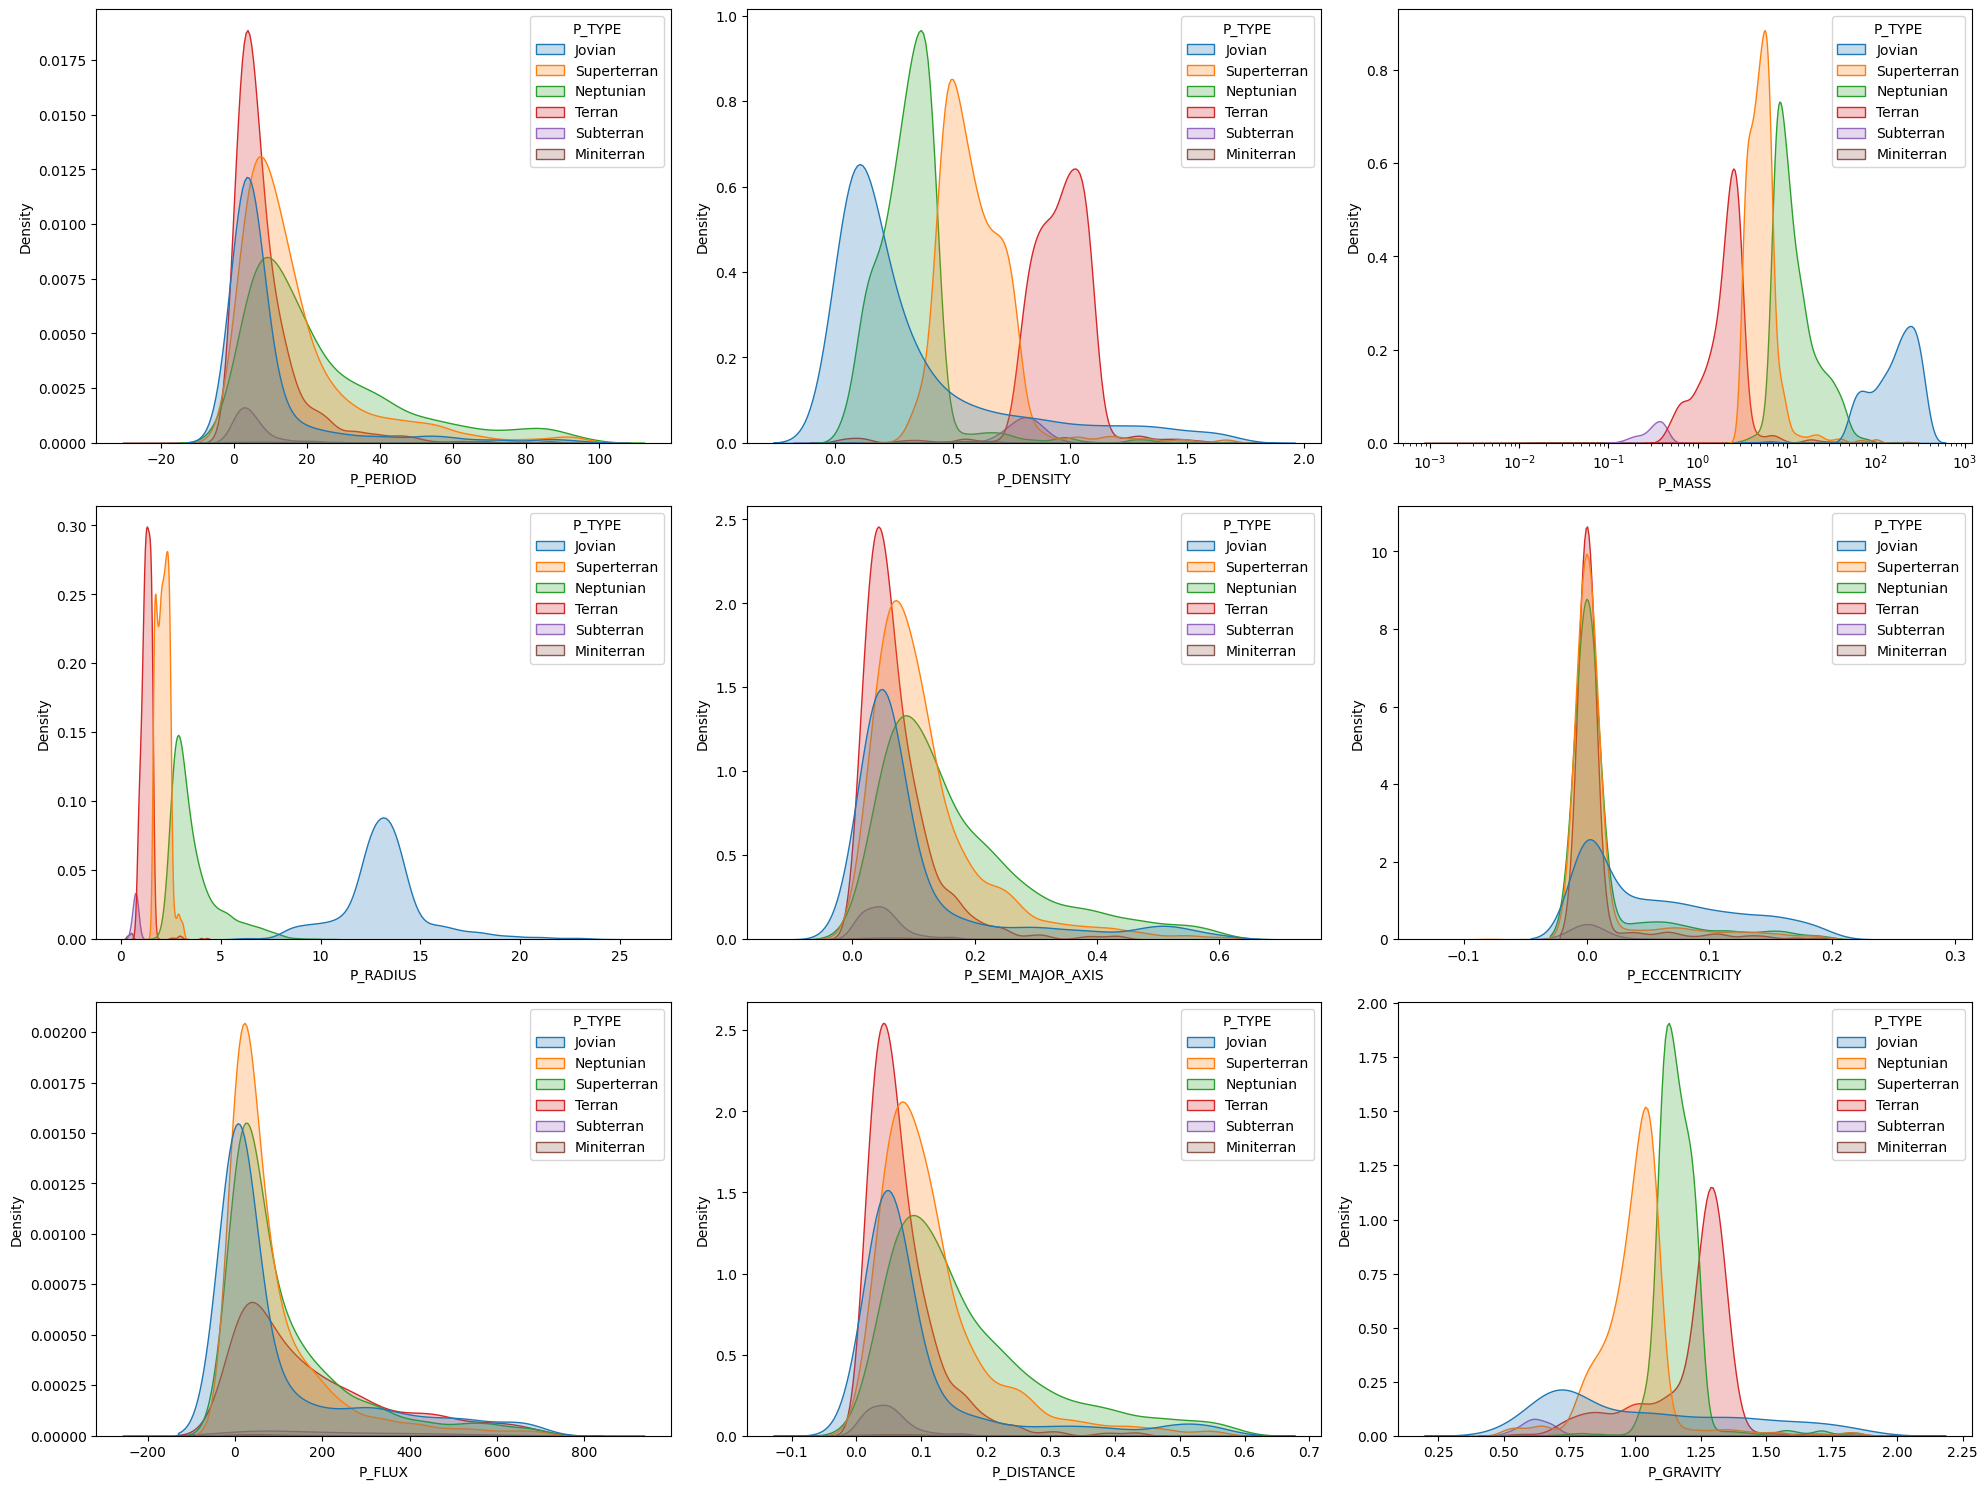

In [9]:
# Conditional Statistics : Conditionally on Planet Type, with log-scale on Planet Mass.

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 15))
sns.kdeplot(data=cleaned_series['df_cleaned_pl_P_PERIOD'], x='P_PERIOD', hue = 'P_TYPE', ax=ax1, fill=True) 
sns.kdeplot(data=cleaned_series['df_cleaned_pl_P_DENSITY'], x='P_DENSITY', hue = 'P_TYPE', ax=ax2, fill=True) 
sns.kdeplot(data=cleaned_series['df_cleaned_pl_P_MASS'], x='P_MASS', hue = 'P_TYPE', ax=ax3, log_scale=True, fill=True) 
sns.kdeplot(data=cleaned_series['df_cleaned_pl_P_RADIUS'], x='P_RADIUS', hue = 'P_TYPE', ax=ax4, fill=True) 
sns.kdeplot(data=cleaned_series['df_cleaned_pl_P_SEMI_MAJOR_AXIS'], x='P_SEMI_MAJOR_AXIS', hue = 'P_TYPE', ax=ax5, fill=True) 
sns.kdeplot(data=cleaned_series['df_cleaned_pl_P_ECCENTRICITY'], x='P_ECCENTRICITY', hue = 'P_TYPE', ax=ax6, fill=True) 
sns.kdeplot(data=cleaned_series['df_cleaned_pl_P_FLUX'], x='P_FLUX', hue = 'P_TYPE', ax=ax7, fill=True) 
sns.kdeplot(data=cleaned_series['df_cleaned_pl_P_DISTANCE'], x='P_DISTANCE', hue = 'P_TYPE', ax=ax8, fill=True) 
sns.kdeplot(data=cleaned_series['df_cleaned_pl_P_GRAVITY'], x='P_GRAVITY', hue = 'P_TYPE', ax=ax9, fill=True) 

xlabels = ['P_PERIOD', 'P_DENSITY', 'P_MASS', 'P_RADIUS', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_FLUX', 'P_DISTANCE', 'P_GRAVITY']

for ax in fig.get_axes():
    ax.spines['left']
    ax.spines['bottom']
    ax.set_ylabel('Density')
    ax_idx = fig.get_axes().index(ax)
    ax.set_xlabel(xlabels[ax_idx])

plt.tight_layout()
plt.show()

Interestingly, and as suggested by the theory, density, mass, radius and gravity are highly specific to each planet types. Jovian planets have a heavy left tailed when it comes to many conditional densities, particularly on their density variable distribution, their eccentricity, their flux and their gravity, suggesting more diversed planets among this type. Their radius is very different from other types.

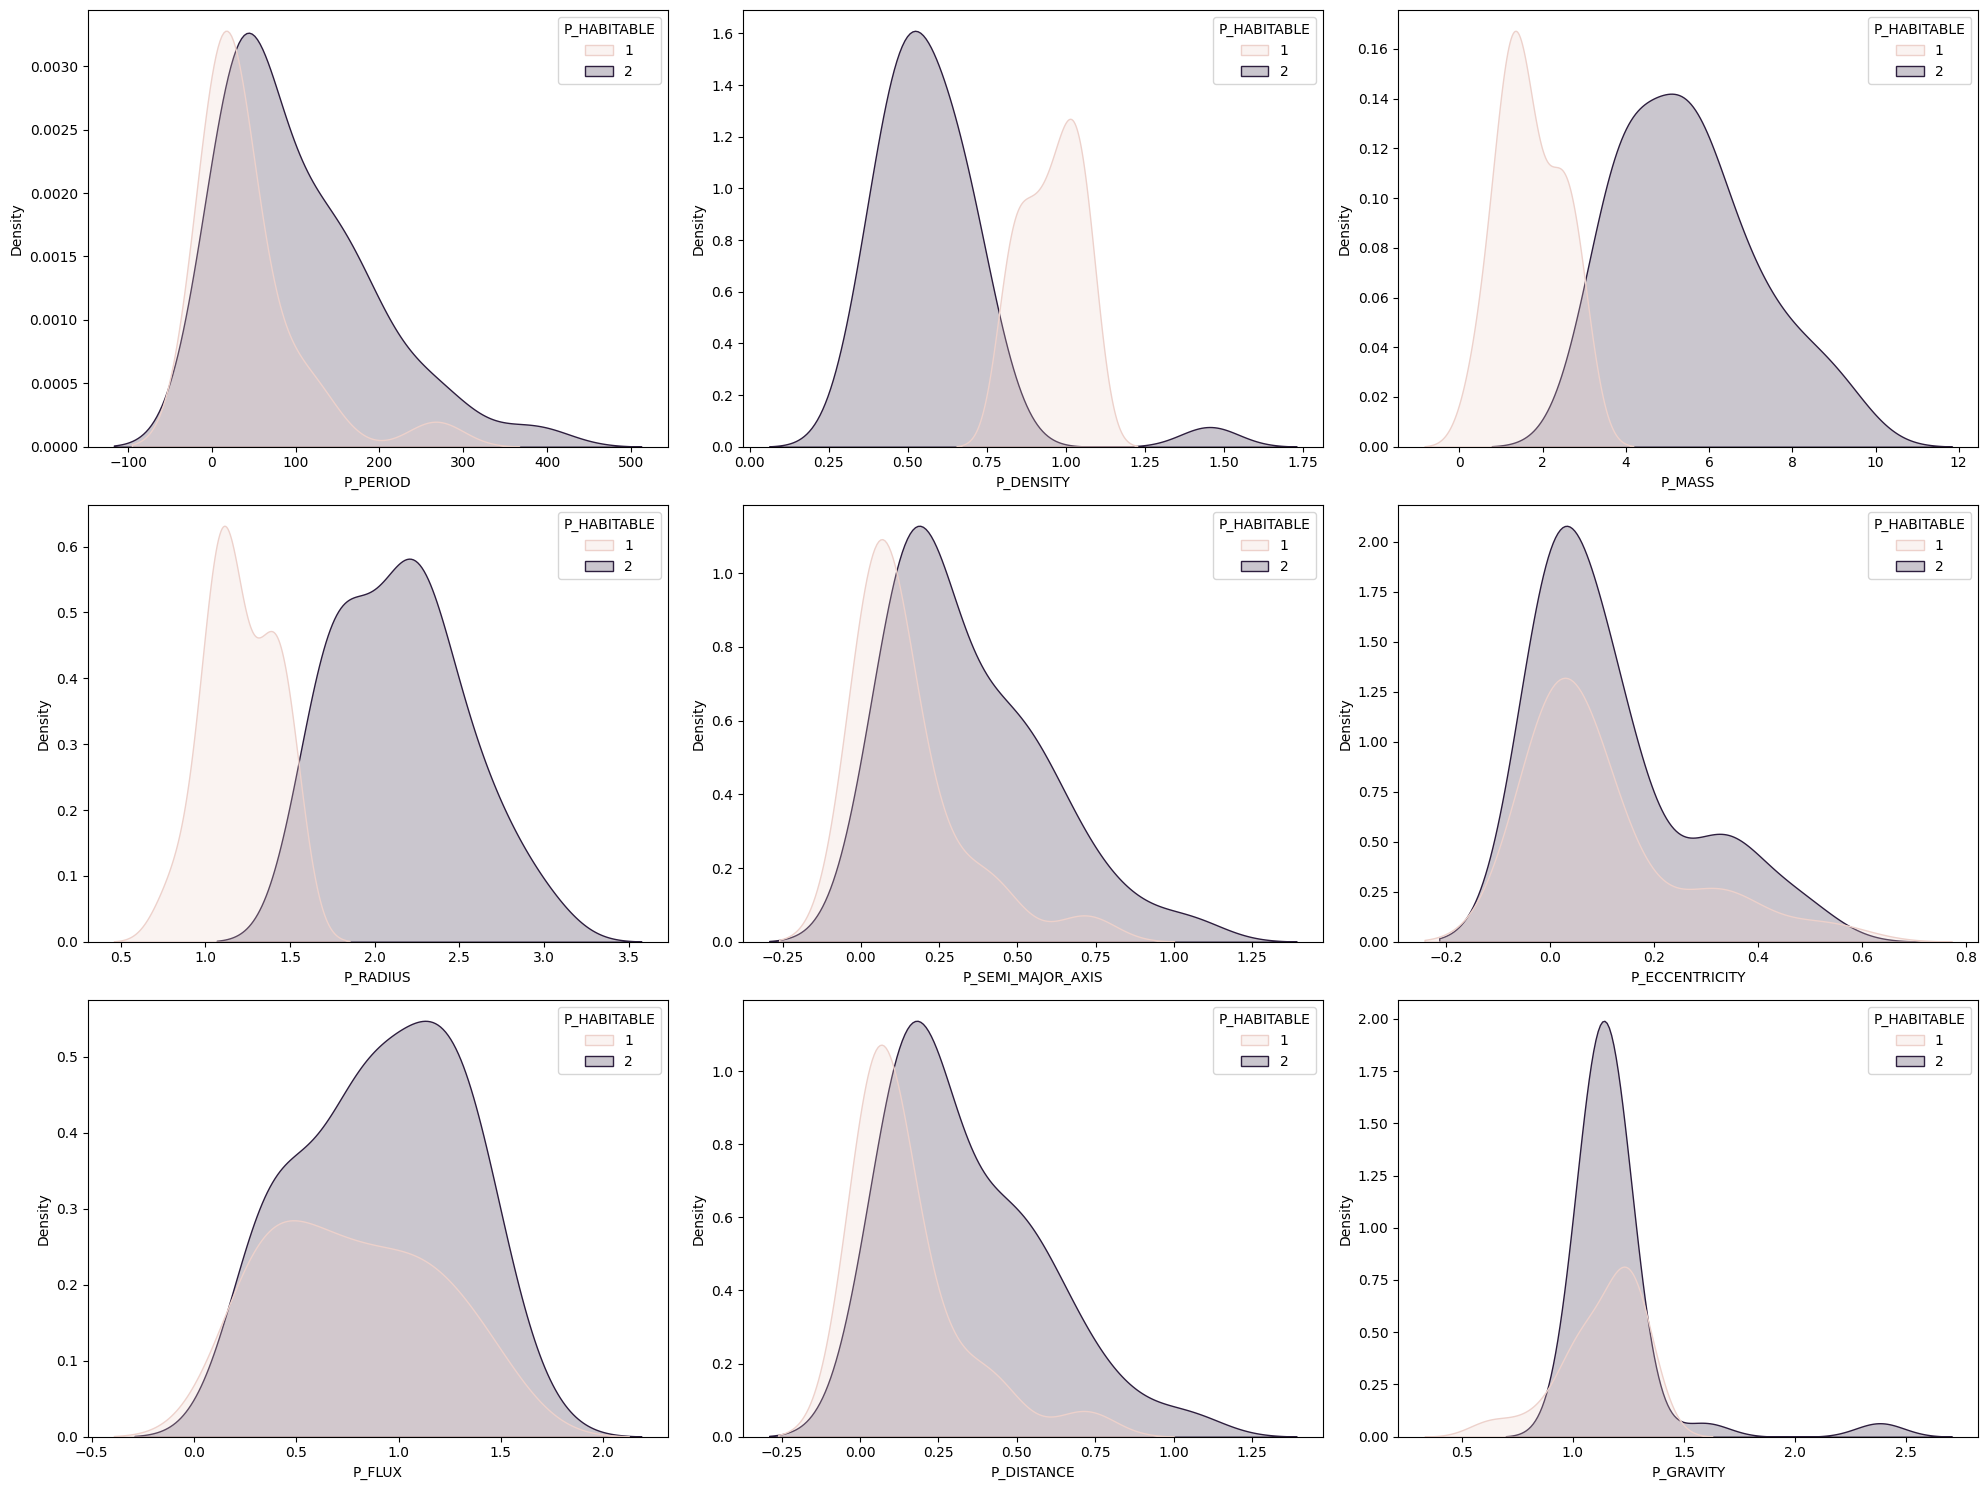

In [10]:
# Conditional Statistics : Conditionally on Habitability type  for planets

df_habitable = df.loc[(df['P_HABITABLE'] == 2) | (df['P_HABITABLE'] == 1)]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 15))
sns.kdeplot(data=df_habitable, x='P_PERIOD', hue = 'P_HABITABLE', ax=ax1, fill=True) 
sns.kdeplot(data=df_habitable, x='P_DENSITY', hue = 'P_HABITABLE', ax=ax2, fill=True)
sns.kdeplot(data=df_habitable, x='P_MASS', hue = 'P_HABITABLE', ax=ax3, fill=True) 
sns.kdeplot(data=df_habitable, x='P_RADIUS', hue = 'P_HABITABLE', ax=ax4, fill=True)
sns.kdeplot(data=df_habitable, x='P_SEMI_MAJOR_AXIS', hue = 'P_HABITABLE', ax=ax5, fill=True)
sns.kdeplot(data=df_habitable, x='P_ECCENTRICITY', hue = 'P_HABITABLE', ax=ax6, fill=True)
sns.kdeplot(data=df_habitable, x='P_FLUX', hue = 'P_HABITABLE', ax=ax7, fill=True)
sns.kdeplot(data=df_habitable, x='P_DISTANCE', hue = 'P_HABITABLE', ax=ax8, fill=True)
sns.kdeplot(data=df_habitable, x='P_GRAVITY', hue = 'P_HABITABLE', ax=ax9, fill=True)

xlabels = ['P_PERIOD', 'P_DENSITY', 'P_MASS', 'P_RADIUS', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_FLUX', 'P_DISTANCE', 'P_GRAVITY']

for ax in fig.get_axes():
    ax.spines['left']
    ax.spines['bottom']
    ax.set_ylabel('Density')
    ax_idx = fig.get_axes().index(ax)
    ax.set_xlabel(xlabels[ax_idx])

plt.tight_layout()
plt.show()

Habitability types for planets mostly differ in their radius, density and their mass. Conservative habitable (1) planets have a higher density, lower mass and radius than Optimistic habitable (2) planets.

Let's now look at their host stars conditionaly on their habitability types.

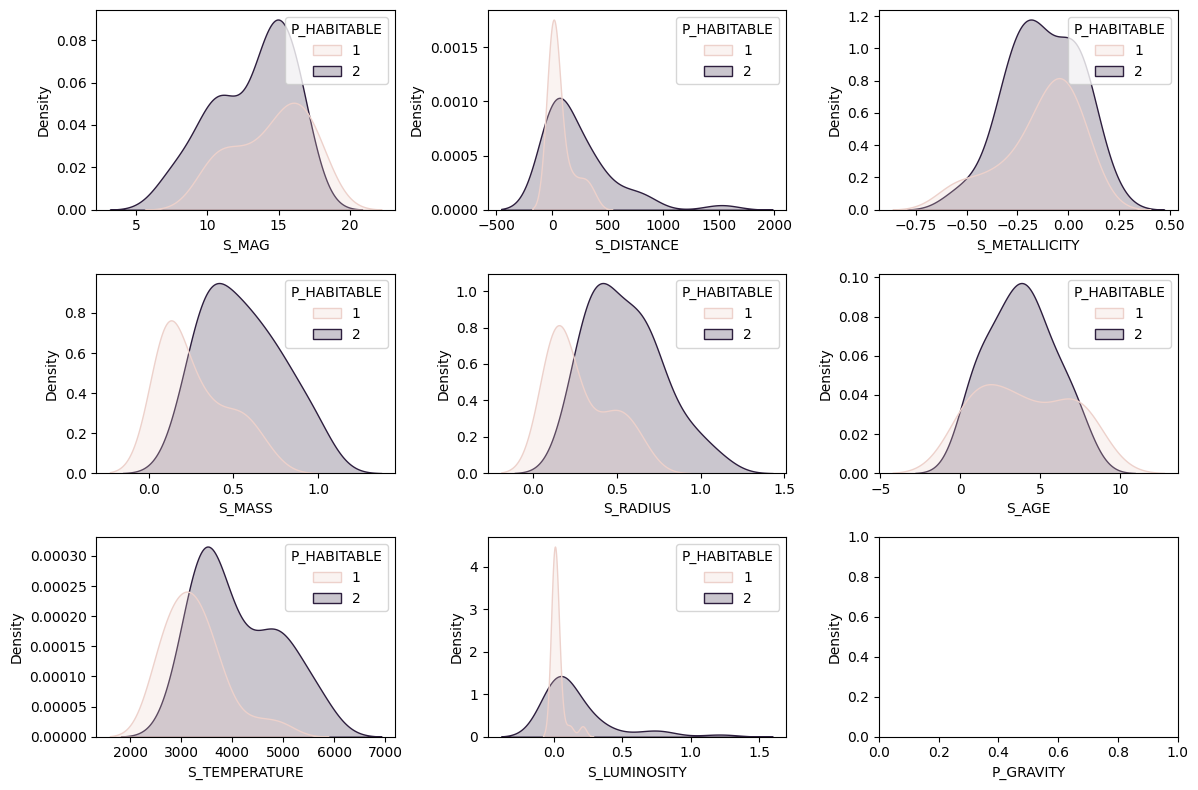

In [11]:
# Conditional Statistics : Conditionally on Habitability type for stars

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 8))
sns.kdeplot(data=df_habitable, x='S_MAG', hue = 'P_HABITABLE', ax=ax1, fill=True)
sns.kdeplot(data=df_habitable, x='S_DISTANCE', hue = 'P_HABITABLE', ax=ax2, fill=True) 
sns.kdeplot(data=df_habitable, x='S_METALLICITY', hue = 'P_HABITABLE', ax=ax3, fill=True)
sns.kdeplot(data=df_habitable, x='S_MASS', hue = 'P_HABITABLE', ax=ax4, fill=True) 
sns.kdeplot(data=df_habitable, x='S_RADIUS', hue = 'P_HABITABLE', ax=ax5, fill=True) 
sns.kdeplot(data=df_habitable, x='S_AGE', hue = 'P_HABITABLE', ax=ax6, fill=True)
sns.kdeplot(data=df_habitable, x='S_TEMPERATURE', hue = 'P_HABITABLE', ax=ax7, fill=True)
sns.kdeplot(data=df_habitable, x='S_LUMINOSITY', hue = 'P_HABITABLE', ax=ax8, fill=True)

xlabels = ['S_MAG', 'S_DISTANCE', 'S_METALLICITY', 'S_MASS', 'S_RADIUS', 'S_AGE', 'S_TEMPERATURE', 'S_LUMINOSITY', 'P_GRAVITY']

for ax in fig.get_axes():
    ax.spines['left']
    ax.spines['bottom']
    ax.set_ylabel('Density')
    ax_idx = fig.get_axes().index(ax)
    ax.set_xlabel(xlabels[ax_idx])

plt.tight_layout()
plt.show()

Stars of planets that are habitable conditionaly on their habitability types differ way less. However, the luminosity of conservative types (1) is much more centered on 0. Similarly for the distance of the star to us : the most probably habitable planets are located in solar systems close to ours.

X-Y relationships

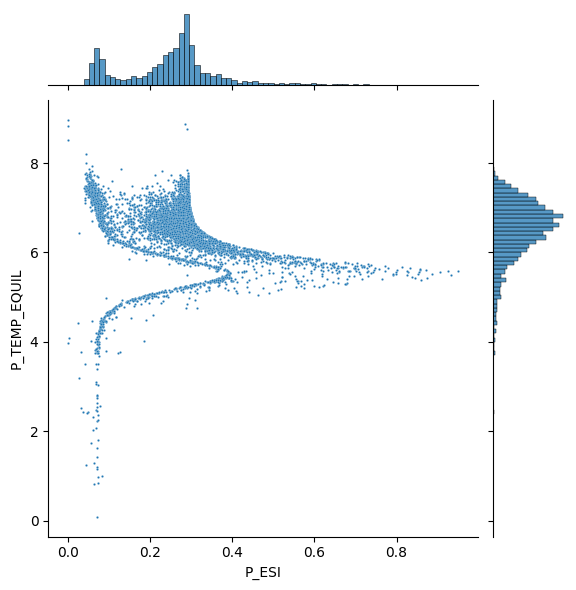

In [18]:
sns.jointplot(y = np.log(df['P_TEMP_EQUIL']), x = df['P_ESI'], s=2.7)

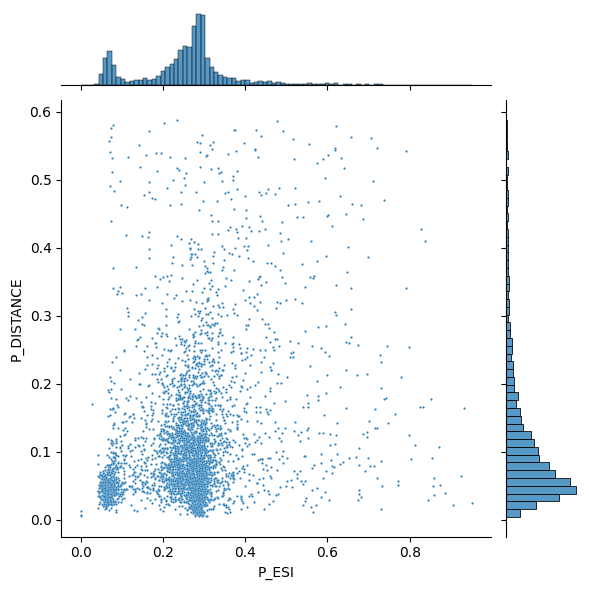

In [14]:
sns.jointplot(data = cleaned_series['df_cleaned_pl_P_DISTANCE'], y = 'P_DISTANCE', x = 'P_ESI', s=2.7)

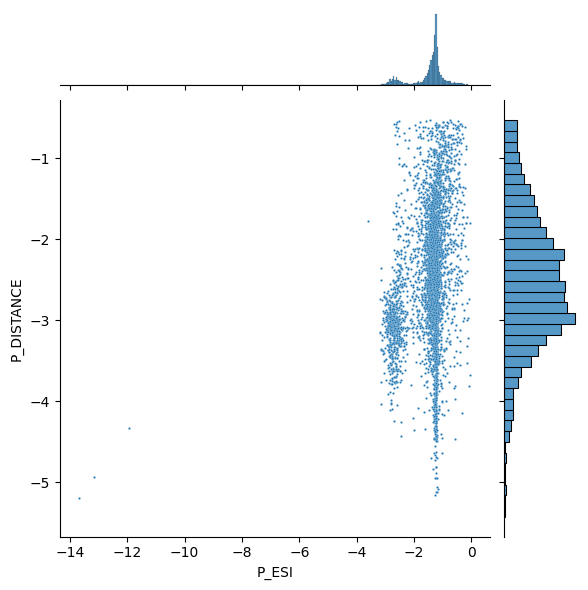

In [17]:
sns.jointplot(y = np.log(cleaned_series['df_cleaned_pl_P_DISTANCE']['P_DISTANCE']), 
              x = np.log(cleaned_series['df_cleaned_pl_P_DISTANCE']['P_ESI']), s=2.7)

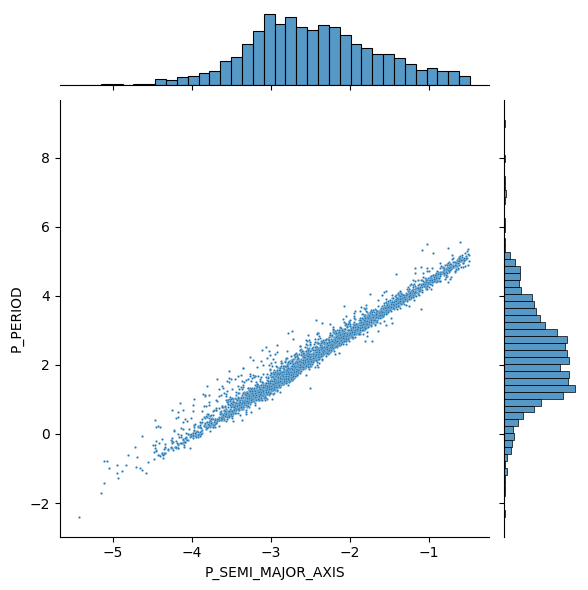

In [14]:
sns.jointplot(y = np.log(cleaned_series['df_cleaned_pl_P_SEMI_MAJOR_AXIS']['P_PERIOD']), 
              x = np.log(cleaned_series['df_cleaned_pl_P_SEMI_MAJOR_AXIS']['P_SEMI_MAJOR_AXIS']), s=2.7)

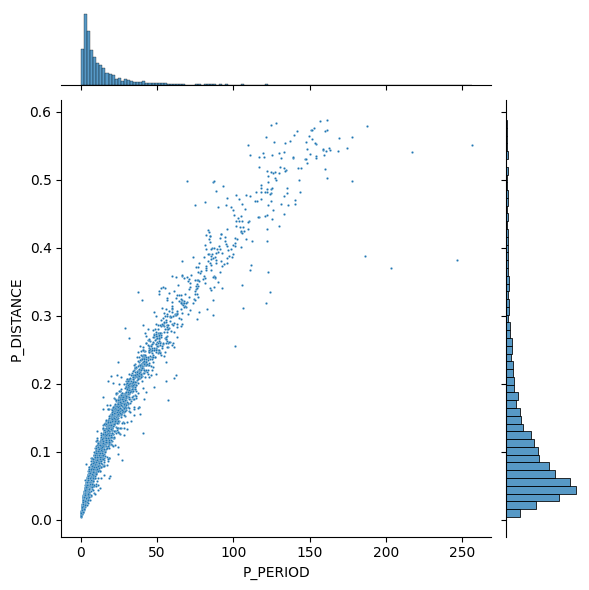

In [15]:
sns.jointplot(data = cleaned_series['df_cleaned_pl_P_DISTANCE'], y = 'P_DISTANCE', x = 'P_PERIOD', s=2.7)

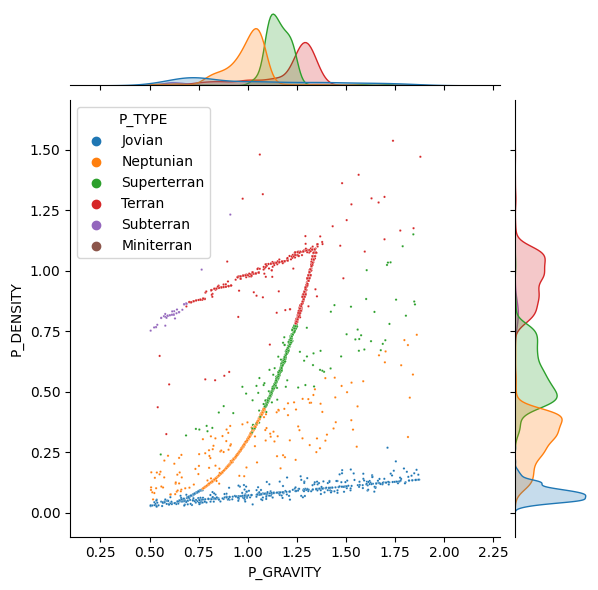

In [16]:
sns.jointplot(data = cleaned_series['df_cleaned_pl_P_GRAVITY'], y = 'P_DENSITY', x = 'P_GRAVITY', hue = 'P_TYPE', s=2.7)

Interpretation : 

Regline plots

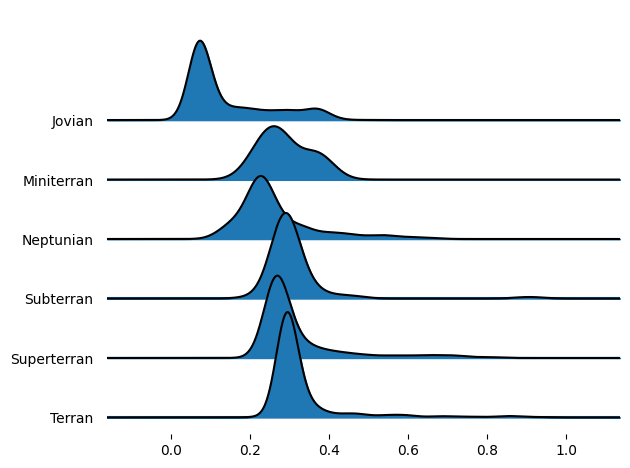

In [18]:
fig, axes = joypy.joyplot(df, by = 'P_TYPE', column='P_ESI')

Jovian planets are centered on a low ESI index value, but have a strong tendency to have high values, with a fat right tail.

Moving on to AT-HYG dataset

In [20]:
df = pd.read_csv('data/at_hyg_data.csv')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12908\2237696649.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/at_hyg_data.csv')


In [21]:
# Filter outliers and store each filtered datsets in a dictionary

cleaned_series = {}

for column in df.columns:
    if column in df.drop(['id', 'hip', 'hd', 'hyg', 'proper', 'ra', 'dec', 'x0', 'y0', 'z0', 'spect', 'host_exoplanet'], axis = 1).columns:
        cleaned_series['df_cleaned_{0}'.format(column)] = outliers_removal(df, column)

Exploratory analysis

In [22]:
print(f'{(df[df["host_exoplanet"] == True]["id"].count()/df.shape[0])*100:.2f} % of stars host exoplanets.')

star_exoplanets = df[df['host_exoplanet']==True]

0.03 % of stars host exoplanets.


Text(0.5, 1.0, 'Correlation')

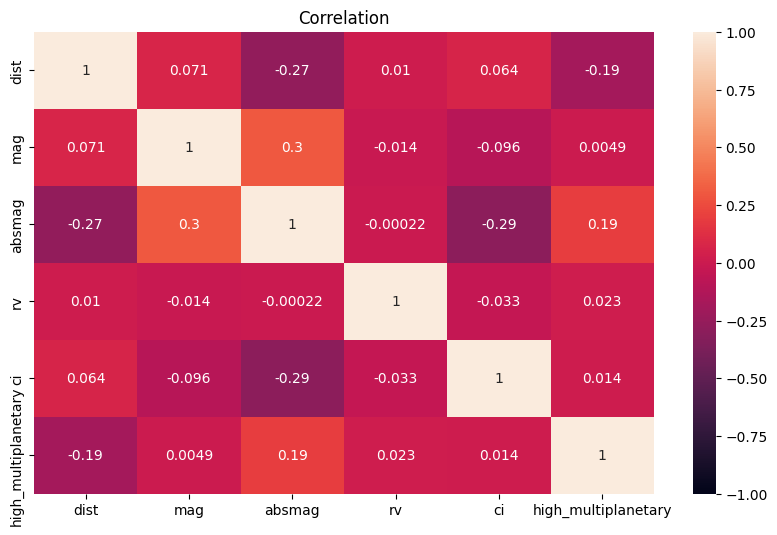

In [23]:
## Correlation

plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df.drop(['id', 'hd', 'hip','hyg', 'ra', 'dec', 'proper', 'x0', 'y0', 'z0', 'spect', 'host_exoplanet'], axis = 1).corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation')

No strong correlation between variables. The highest one is between mag and absmag which are obvisouly correlated features, but suprisingly, not that much correlation.

In [24]:
dabl.plot(df.sample(100000), target_col='host_exoplanet')

NameError: name 'dabl' is not defined

Comments : 

Let's redo the Hertzsprung-Russell Diagram, which was used to study stars populations to set the theory of stellar evolution. The role of this diagram is to classify stars of a same spectral type in different classes of luminosity based on their surface temperature. In our case, we are going to use the absolute magnitude and the color index, both available in AT-HYG dataset.

In [25]:
# Hertzsprung-Russell Diagram

fig = go.Figure(data=go.Scatter(
    x=df[df['hyg'].notna()]['ci'], 
    y=df[df['hyg'].notna()]['absmag'], 
    mode='markers',
    marker=dict(color='lightblue', size=2.2) 
))

# Customize the layout
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    title='Hertzsprung-Russell Diagram',
    title_font_color='black',
    font_color='black',
    xaxis=dict(
        title='Color Index (B-V)',
        range=[-0.5, 2.5],
        tickvals=np.linspace(0, 2, 3, endpoint=True),
        showline=True,
        linecolor='black',
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        title='Absolute Magnitude',
        range=[18, -16],
        tickvals=np.linspace(20, -10, 3, endpoint=True),
        showline=True,
        linecolor='black',
        showgrid=False,
        zeroline=False
    ),
    height=800,
    width=600
)

annotations = [
    dict(x=0.7, y=6.5, xref='x', yref='y', text='main sequence', font=dict(color='black', size=17)),
    dict(x=1.8, y=-1, xref='x', yref='y', text='giants', font=dict(color='black', size=17)),
    dict(x=0.5, y=-14, xref='x', yref='y', text='supergiants', font=dict(color='black', size=17)),
    dict(x=0, y=12, xref='x', yref='y', text='white dwarfs', font=dict(color='black', size=17))
]
fig.update_layout(annotations=annotations)

fig.show()

It is possible to do a similar graph, but it seems to lack supergiants where I annonated it.

Lets take a look at the spectral types of stars hosting exoplanets.

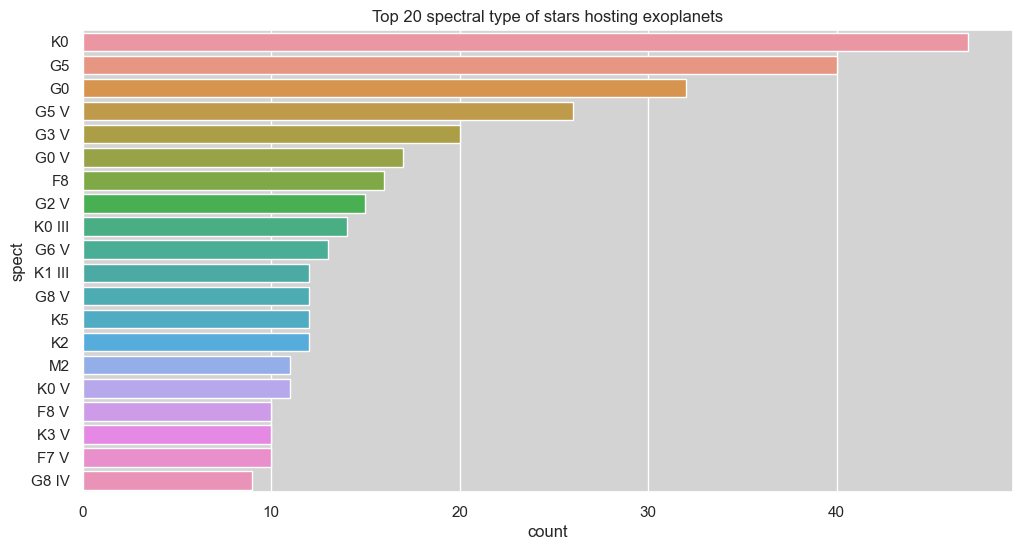

In [26]:
## Look at the spectral types barplot of stars hosting exoplanets

spect_count = star_exoplanets['spect'].value_counts()

# get the top 10 most frequent telescopes.
top_spect = spect_count.head(20).index

sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white'})

fig, ax = plt.subplots(figsize=(12, 6))
ax.spines['left']
ax.spines['bottom']
ax.set_xlabel('Count')
ax.set_ylabel('Number of observations')
ax.set_title('Top 20 spectral type of stars hosting exoplanets')
sns.countplot(y='spect', data=star_exoplanets, order=top_spect, ax=ax)
plt.show()

Most stars are of K0 types, followed by G5. For comparison, our Sun is of type G2V, which is not the most representative one.

Conditional densities

IndexError: list index out of range

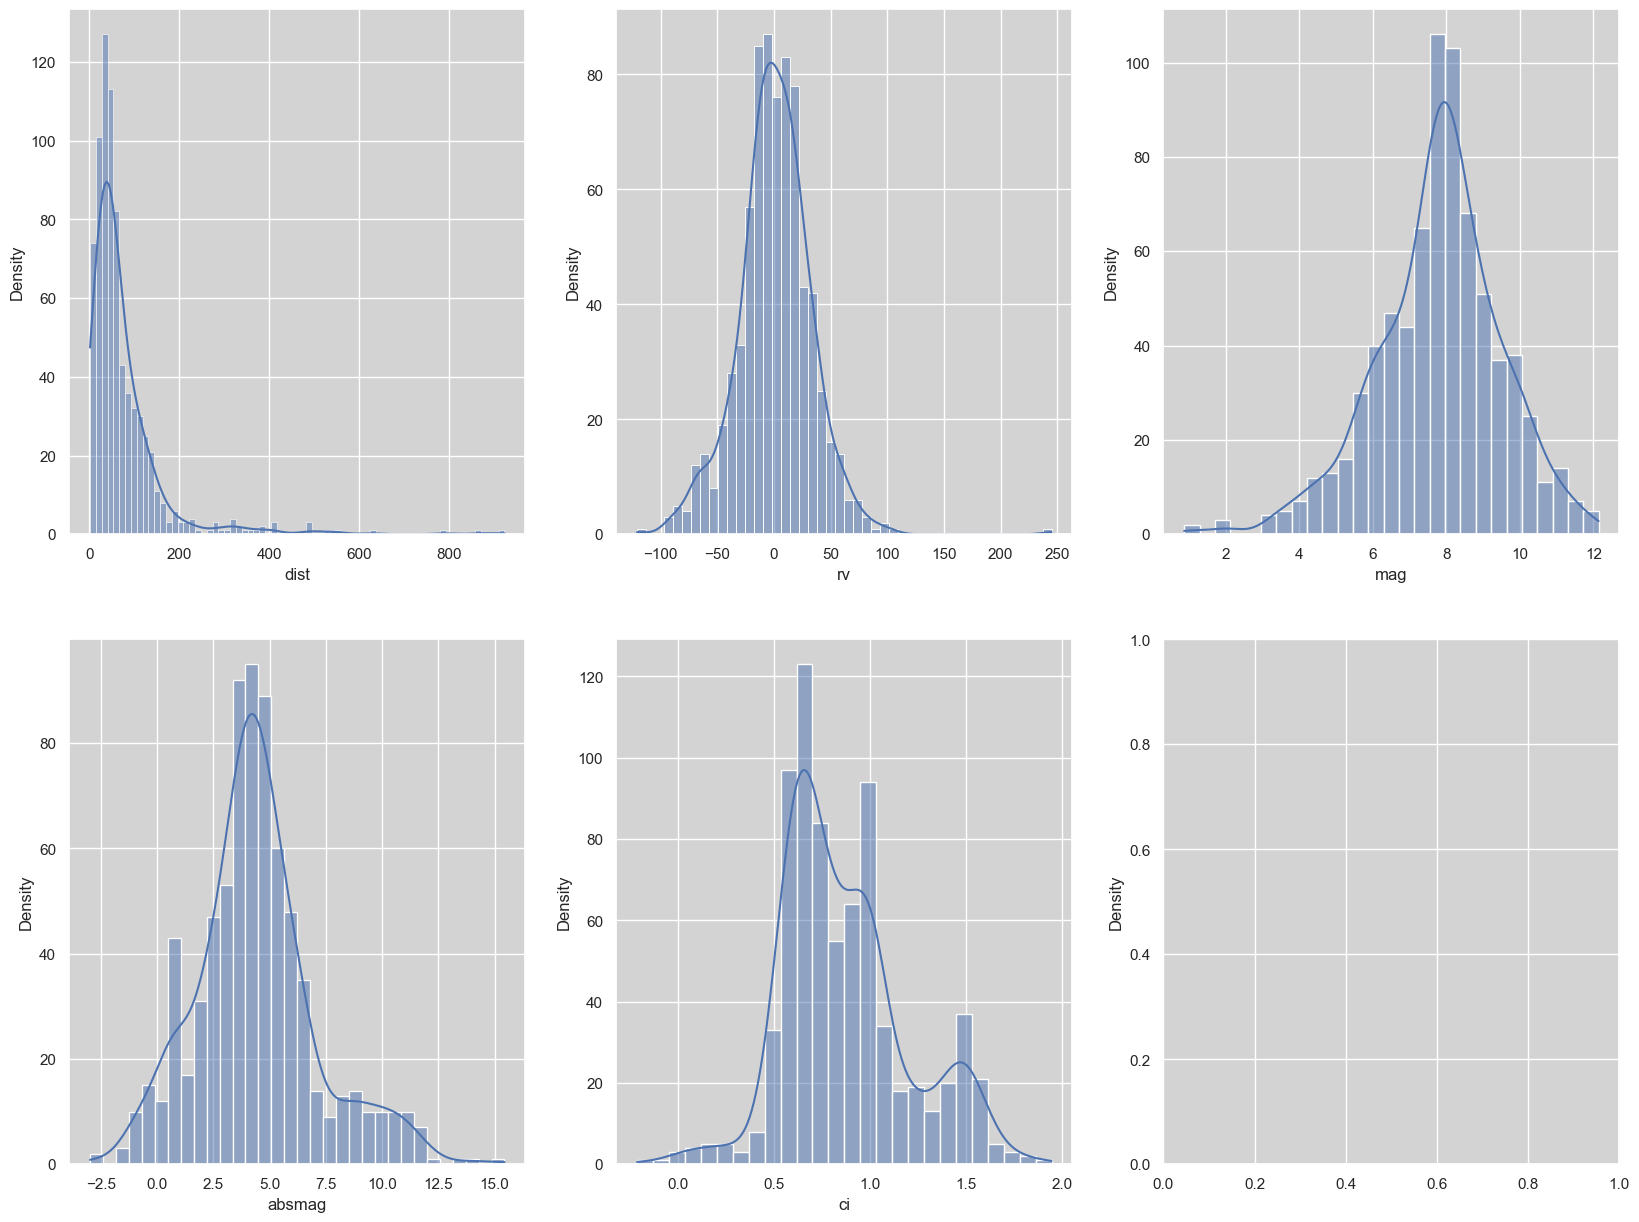

In [27]:
## Densities conditionally on hosting exoplanets

at_hyg_data_exoplanet = df[df['host_exoplanet']==True]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 15))
sns.histplot(data=at_hyg_data_exoplanet, x='dist', ax=ax1, kde=True)
sns.histplot(data=at_hyg_data_exoplanet, x='rv', ax=ax2, kde=True)
sns.histplot(data=at_hyg_data_exoplanet, x='mag', ax=ax3, kde=True)
sns.histplot(data=at_hyg_data_exoplanet, x='absmag', ax=ax4, kde=True)
sns.histplot(data=at_hyg_data_exoplanet, x='ci', ax=ax5, kde=True)

xlabels = ['dist', 'rv', 'mag', 'absmag', 'ci']

for ax in fig.get_axes():
    ax.spines['left']
    ax.spines['bottom']
    ax.set_ylabel('Density')
    ax_idx = fig.get_axes().index(ax)
    ax.set_xlabel(xlabels[ax_idx])

plt.tight_layout()
plt.show()

Not too strange histograms, however dist needs to be checked : do we have a right heavy tailed distribution ? Let's check the descending ecdf first.

<AxesSubplot: xlabel='dist', ylabel='Proportion'>

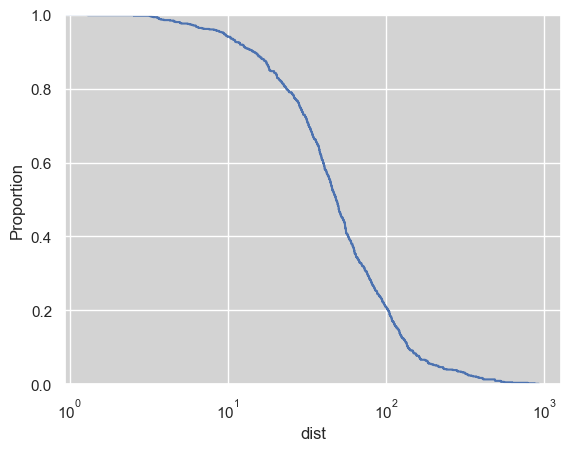

In [35]:
sns.ecdfplot(data=at_hyg_data_exoplanet, x='dist', log_scale=True, complementary=True) 

We don't have a power law, but more certainly a log normal distribution. Let's try to fit it to different distributions to be sure, using the q-q plot.

Text(0.5, 0, 'Theoretical Quantiles')

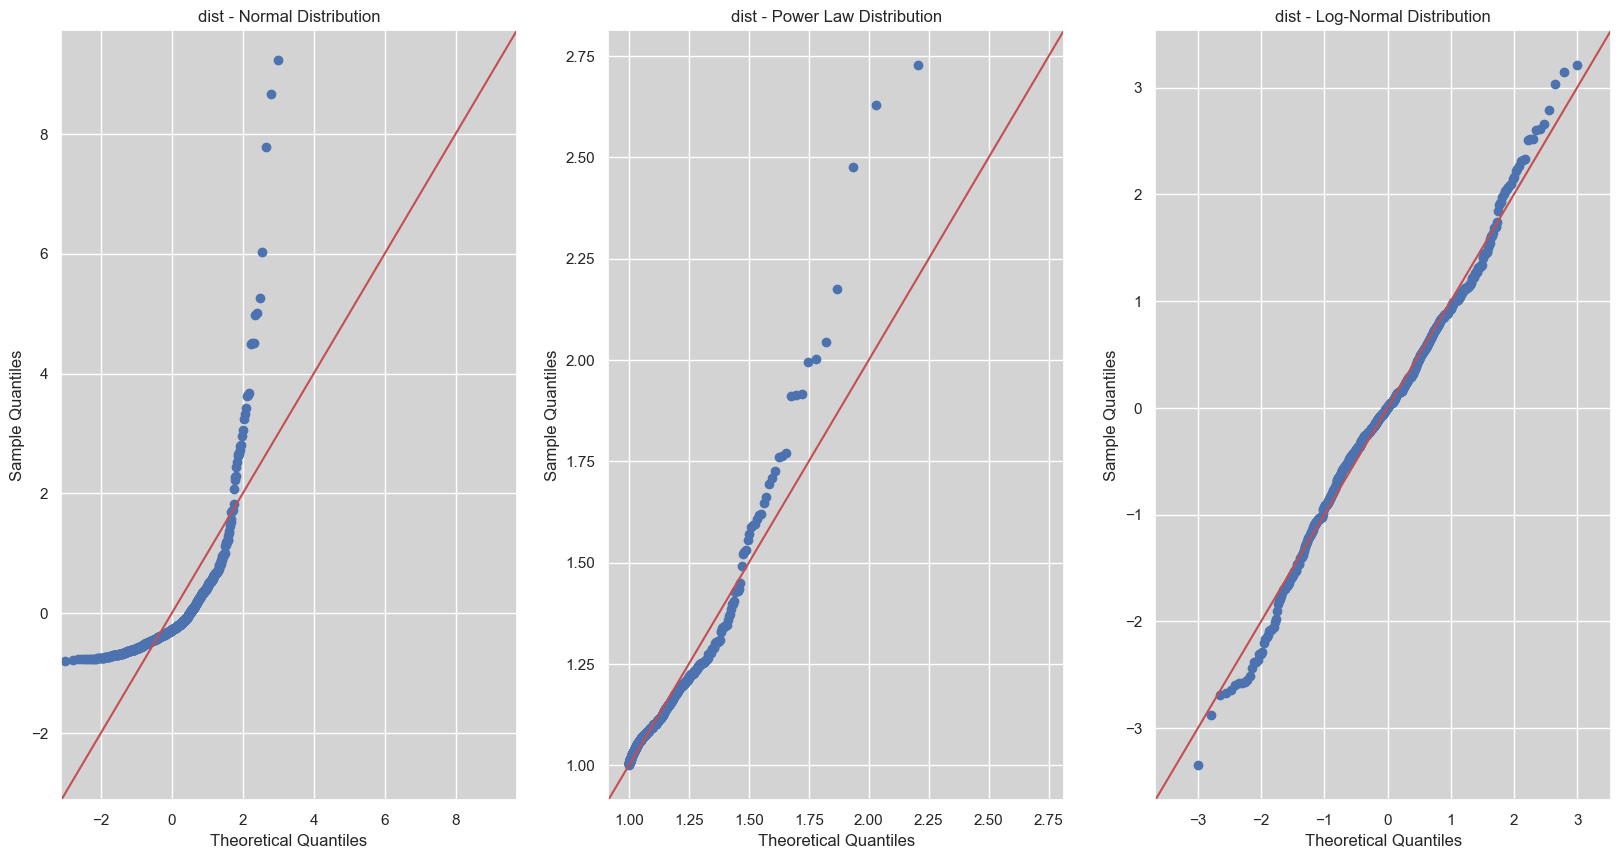

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

sm.qqplot(at_hyg_data_exoplanet['dist'], stats.norm, line='45', fit=True, ax=ax1)
ax1.set_title('dist - Normal Distribution')
ax1.set_xlabel('Theoretical Quantiles')
ax1.set_ylabel('Sample Quantiles')
sm.qqplot(at_hyg_data_exoplanet['dist'], stats.pareto, line='45', fit=True, ax=ax2)
ax2.set_title('dist - Power Law Distribution')
ax2.set_xlabel('Theoretical Quantiles')
logged_data = np.log(at_hyg_data_exoplanet['dist'] + 1)
sm.qqplot(logged_data, stats.norm, line='45', fit=True, ax=ax3)
ax3.set_title('dist - Log-Normal Distribution')
ax3.set_xlabel('Theoretical Quantiles')

We do have a log normal distribution, but it isn't too far from a power law. It suggests that stars hosting exoplanets (those that we could matched) are also quite far from us.